# Diffusion with stochastic resetting
*09-Nov-21* 

Nowadays, one of the most explored problems in stochastic processes nowadays is the problem of stochastic resetting, meaning that a particle is reset to the initial (or any other) position from time to time. The one-dimensional Brownian motion with Markovian resetting with a constant resetting rate $r$ is introduced by Evans and Majumdar \cite{maj1}. It was shown that the solution for the PDF, approaches a non-equilibrium steady state and in the long time limit, its MSD is saturated, $\langle x^{2}(t)\rangle\sim 1/r$, see also the review paper \cite{reset_review} for more details.

The Fokker-Planck equation for a diffusion process with stochastic resetting reads
$$
\frac{\partial}{\partial t}P_{r}(x,t)=\mathcal{D}_{x}\frac{\partial^2}{\partial x^2}P_{r}(x,t)-rP_{r}(x,t)+r\delta(x-x_0)
$$


with initial condition $P_{r}(x,t=0)=\delta(x-x_0)$. Here $r$ is the rate of resetting to the initial position $x_0$. The last two terms of the equation represent the loss of the probability from position $x$ due to the reset to the initial position, and the gain of the probability at $x_0$ due to resetting from all other positions, respectively. This equation means that between any two consecutive resetting events the particle undergoes diffusion with the constant drift.

This process can be simulated by using Langevin equation approach. We consider the Langevin equation in the presence of stochastic resetting to the initial position


\begin{align}
x(t+\Delta t)=\left\lbrace\begin{array}{lll}
     & x(0), &\textrm{with probability}\, r\Delta t,\\
     & x(t)+\sqrt{2\mathcal{D}\Delta t}\,\zeta(t), & \textrm{with probability}\, (1-r\Delta t).
\end{array} \right.
\end{align}

<br>


where $\zeta(t)$ is a zero mean Gaussian noise, and $\mathcal{D}$ and $r$ are diffusion coefficient and resetting rate, respectively. This effect of stochastic resetting is modeled by sampling a resetting time from an exponential distribution with parameter $r$ representing the time between two events in a Poisson point process. During this resetting time, the particle undergoes free diffusion and resets at $x_0$ afterward. 


# A. Main class

In [8]:
"""
 
    Created on 27-Oct-2021
    @author: zelenkastiot
    
    bm-speed: 

 """

import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random
from matplotlib.ticker import (AutoMinorLocator)
from math import gamma
import psutil
from multiprocessing import Pool

# Get number of CPU cores
num_cpus = psutil.cpu_count(logical=False)

warnings.filterwarnings("ignore")

# Specifying the figure parameters
font = {'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 18,
        }
params = {'legend.fontsize': 10,
          'legend.handlelength': 2.}
plt.rcParams.update(params)

reset_points = []


# Brownian motion stochastic process
class BrownianMotionLangevin:
    """
    This class contains methods that solve different variations of the Brownian motion stochastic process:
        *time_1d_reset   -  1D Brownian motion, Langevin Eq., with stochastic resetting
        *time_1d_regular -  1D Brownian motion, Langevin Eq., no stochastic resetting
        *time_2d_regular -  2D Brownian motion, 2D comb, Langevin Eq., no stochastic resetting
        *time_3d_regular -  3D Brownian motion, 3D comb, Langevin Eq., no stochastic resetting
    """

    # Function for validating # of coefficients
    def check_coefficients(self, diffusion_coefficients):
        """
        Simple input check for # of diffusion coefficients.
        If not valid (logical) raises warning with message

        :param diffusion_coefficients: List of dc
        :return: None
        """
        if self.ensemble_type == '1d':
            if len(diffusion_coefficients) == 1:
                self.diffusion_coefficient_x = diffusion_coefficients[0]
            else:
                raise ValueError(
                    "You must have one (Dx) diffusion coefficient!"
                )

        if self.ensemble_type == '2d':
            if len(diffusion_coefficients) == 2:
                self.diffusion_coefficient_x = diffusion_coefficients[0]
                self.diffusion_coefficient_y = diffusion_coefficients[1]
            else:
                raise ValueError(
                    "You must have exactly two (Dx, Dy) diffusion coefficients!"
                )

        if self.ensemble_type == '3d':
            if len(diffusion_coefficients) == 3:
                self.diffusion_coefficient_x = diffusion_coefficients[0]
                self.diffusion_coefficient_y = diffusion_coefficients[1]
                self.diffusion_coefficient_z = diffusion_coefficients[2]
            else:
                raise ValueError(
                    "You must have exactly three (Dx, Dy, Dz) diffusion coefficients!"
                )

    # A(y): Mimicking the Dirac-delta function on axis Y
    def a_dirac(self, y=0):
        """
        Mimicking the Dirac-delta function on axis Y

        :param self: Brownian motion object
        :param y   - value we are interested in ~ A(y)
        """
        # Calculate A(y)
        f1 = 1 / (2 * np.pi) ** 0.5 * np.exp(-y ** 2 / (2 * self.sigma ** 2)) / self.sigma
        # Return the square (since we use it inside the square root)
        return f1 ** 0.5

    # B(z): Mimicking the Dirac-delta function on axis Z
    def b_dirac(self, z=0):
        """
        Mimicking the Dirac-delta function on axis Z

        :param self: Brownian motion object
        :param z   - value we are interested in ~ B(z)

        """
        # Calculate A(y)
        f2 = 1 / (2 * np.pi) ** 0.5 * np.exp(-z ** 2 / (2 * self.sigma ** 2)) / self.sigma
        # Return the square (since we use it inside the square root)
        return f2 ** 0.5

    # Special case: Returns the reset points for 1D Brownian motion with stochastic resetting
    def time_1d_reset_plot(self):
        # prob_reset = self.reset_rate * self.dt
        prob_reset = random.expovariate(self.reset_rate * self.dt)
        # Define the solution as [dimension, time] (in this case 1)
        s = np.zeros((len(self.times)))
        s[0] = self.start_pos

        # Loop over time
        for t in range(1, len(self.times) - 1):
            # step = np.random.uniform(0, 1)

            if t > prob_reset:
                s[t + 1] = s[0]
                prob_reset = random.expovariate(self.reset_rate * self.dt) + t
                self.reset_points.append((t + 1) * self.dt)

            else:
                dwx = self.drift * self.dt + self.sqrt_2Dx * self.sqrt_dt * np.random.normal()
                s[t + 1] = s[t] + dwx

        return s

    # 1st: Function for enhancing speed
    def time_1d_reset(self, i=0):
        # prob_reset = self.reset_rate * self.dt
        prob_reset = random.expovariate(self.reset_rate * self.dt)
        # Define the solution as [dimension, time] (in this case 1)
        s = np.zeros((len(self.times)))
        s[0] = self.start_pos

        # Loop over time
        for t in range(1, len(self.times) - 1):
            # step = np.random.uniform(0, 1)

            if t > prob_reset:
                s[t + 1] = s[0]
                prob_reset = random.expovariate(self.reset_rate * self.dt) + t

            else:
                dwx = self.drift * self.dt + self.sqrt_2Dx * self.sqrt_dt * np.random.normal()
                s[t + 1] = s[t] + dwx

        return s

    # 2nd: Function for enhancing speed
    def time_1d_regular(self, i=0):
        s = np.zeros((len(self.times)))

        # Loop over time
        for t in range(len(self.times) - 1):
            s[t + 1] = s[t] + self.drift * self.dt + self.sqrt_2Dx * self.sqrt_dt * np.random.normal()

        return s

    # 3rd: Function for enhancing speed
    def time_2d_regular(self, i=0):
        # Define the solution as [dimension, time] (in this case 2)
        s2 = np.zeros((2, len(self.times)))

        # Loop over time
        for t in range(len(self.times) - 1):
            # Calculate white gaussian noise ~ (2*Dc*dt)^0.5 * N(0, 1)
            dwx = self.sqrt_2Dx * self.sqrt_dt * np.random.normal()
            dwy = self.sqrt_2Dy * self.sqrt_dt * np.random.normal()

            # Y - axis: Langevin eq. y[t + 1] = y[t] + (2*Dy*dt)^0.5 * N(0, 1)
            s2[1][t + 1] = s2[1][t] + dwx
            # X - axis: Langevin eq. x[t + 1] = x[t] + A(y[t])*(2*Dy*dt)^0.5 * N(0, 1)
            s2[0][t + 1] = s2[0][t] + 0.5 * (self.a_dirac(s2[1][t]) + self.a_dirac(s2[1][t + 1])) * dwy

        return s2

    # 4th: Function for enhancing speed
    def time_3d_regular(self, i=0):
        s3 = np.zeros((3, len(self.times)))

        for t in range(len(self.times) - 1):
            # Calculate white gaussian noise ~ (2*Dc*dt)^0.5 * N(0, 1)
            dwx = self.sqrt_2Dx * self.sqrt_dt * np.random.normal()
            dwy = self.sqrt_2Dy * self.sqrt_dt * np.random.normal()
            dwz = self.sqrt_2Dz * self.sqrt_dt * np.random.normal()

            # Z - axis: Langevin eq. z[t + 1] = z[t] + dwz
            s3[2][t + 1] = s3[2][t] + dwz
            # Y - axis: Langevin eq. y[t + 1] = y[t] + 0.5 * (B(z[t]) + B(z[t + 1]) * dwy
            s3[1][t + 1] = s3[1][t] + 0.5 * (self.b_dirac(s3[2][t]) + self.b_dirac(s3[2][t + 1])) * dwy
            # X - axis: Langevin eq. x[t + 1] = x[t] + 0.5 * { A(y[t]) * B(z[t]) + A(y[t+1]) * B(z[t+1]) } * dwx
            s3[0][t + 1] = s3[0][t] + 0.5 * (
                    self.a_dirac(s3[1][t]) * self.b_dirac(s3[2][t]) + self.a_dirac(s3[1][t + 1]) * self.b_dirac(
                s3[2][t + 1])) * dwx

        return s3

    # Solving 1D
    def solve(self):
        """
        Regular Brownian Motion

        Generates all step based the definition for BM, using 2 different approaches.
        Both draw from a Normal Distribution ~ N(0, dt); If dt=1, it is N(0, 1)

        B = B0 + B1*dB1 + ... Bn*dBn = x + v*dt + (2*Dc*dt)^1/2 * N(0, dt)

        :return: None
        """

        if self.reset_rate is not None:
            # Run ensemble
            print("-------------Started calculating ensemble (1D, RESET)---------------")
            pool = Pool(6)
            monte_carlo1d = list(
                tqdm(pool.imap(self.time_1d_reset, range(self.ensemble_size)), total=self.ensemble_size))
            pool.terminate()
            print(np.shape(monte_carlo1d))

        else:
            # Run ensemble
            print("-------------Started calculating ensemble (1D, NO RESET)------------")
            pool = Pool(self.num_cores)
            monte_carlo1d = list(
                tqdm(pool.imap(self.time_1d_regular, range(self.ensemble_size)), total=self.ensemble_size))
            pool.terminate()

        # Append solution
        self.solution = monte_carlo1d

    # Solving 2D
    def solve2d(self):
        """
        Backbone solution - 2d

        Generates all step based the definition of the backbone.
        - 1st dimension [x] - non-Brownian variable; distribution of waiting
        - 2nd dimension [y] - Brownian motion variable

        Returns the 2D solution of shape (dimension)(values at t time)

        :return: None
        """

        if self.reset_rate is not None:
            # Run ensemble
            print("----- WORK IN PROGRESS ----")
            monte_carlo2d = None

        else:
            # Run ensemble
            print("-------------Started calculating ensemble (2D, NO RESET)------------")

            pool = Pool(self.num_cores)
            monte_carlo2d = list(
                tqdm(pool.imap(self.time_2d_regular, range(self.ensemble_size)), total=self.ensemble_size))
            pool.terminate()

        # Append solution
        self.solution = monte_carlo2d

    # Solving 3D
    def solve3d(self):
        """
        Backbone solution - 3d

        Generates all step based the definition of the backbone.
        - 1st dimension [x] - non-Brownian variable - 1; distribution of waiting
        - 2nd dimension [y] - non-Brownian variable - 2; distribution of waiting
        - 3rd dimension [z] - Brownian motion variable

        Returns the 2D solution of shape (dimension)(values at t time)

        :return: r
        """

        if self.reset_rate is not None:
            # Run ensemble
            print("----- WORK IN PROGRESS ----")
            monte_carlo3d = None

        else:
            # Run ensemble
            print("----- Started calculating ensemble (3D, NO RESET) ----")

            pool = Pool(self.num_cores)
            monte_carlo3d = list(
                tqdm(pool.imap(self.time_3d_regular, range(self.ensemble_size)), total=self.ensemble_size))
            pool.terminate()

        self.solution = monte_carlo3d

    # Functions that runs ensemble using multiprocessing
    def run_ensemble(self):
        # 1d - regular BM
        if self.ensemble_type == '1d':
            self.solve()

        # 2d - 2d comb BM
        elif self.ensemble_type == '2d':
            self.solve2d()

        # 3d - 3d comb BM
        elif self.ensemble_type == '3d':
            self.solve3d()

        # No valid options
        else:
            raise ValueError(
                "Invalid option for 'ensemble type'!",
                "\n\t    Options are:",
                " - '1d'",
                "\n\t\t         - '2d'",
                "\n\t\t         - '3d'"
            )

    # plt_traj==True: Plots trajectories
    def plot_trajectories(self):
        """

        :return:
        """
        if self.reset_rate is not None:
            # DONE
            if self.ensemble_type == '1d':
                # Matplotlib subplot
                fig, (ax0) = plt.subplots(1, 1, figsize=(5, 4), dpi=120)

                # Get parameters
                dif_x = self.diffusion_coefficient_x
                rate = self.reset_rate
                dt = self.dt
                r = self.time_1d_reset_plot()
                # print(self.reset_points)

                # Plot the two axis
                times = np.arange(0, self.simulation_time + 1, self.dt)

                plt.axhline(y=0, linewidth=1, alpha=0.9, color="black", linestyle='--')

                # X-axis
                ax0.scatter(self.reset_points, [0] * (len(self.reset_points)), c="black", s=30, zorder=2)
                ax0.plot(times, r, color="#045a8d", linewidth=0.9, zorder=1)
                ax0.set_xlabel(r'time, $t$')
                ax0.set_ylabel(r'$x(t)$')
                ax0.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)

                if self.simulation_time == 10_000:
                    ax0.set_xticklabels(
                        ["0", r"2$\times 10^3$", r"4$\times 10^3$", r"6$\times 10^3$", r"8$\times 10^3$", r"$10^4$"])
                elif self.simulation_time == 100_000:
                    ax0.set_xticklabels(
                        ["0", r"2$\times 10^4$", r"4$\times 10^4$", r"6$\times 10^4$", r"8$\times 10^4$", r"$10^5$"])

                for i in range(len(self.reset_points)):
                    fill_color = '#e5eef3' if i % 2 == 0 else 'white'

                    first = self.reset_points[i]
                    last = self.simulation_time if i == len(self.reset_points) - 1 else self.reset_points[i + 1]

                    ax0.axvspan(first, last, color=fill_color, alpha=0.5, lw=0, zorder=0)

                plt.xlim(0, self.simulation_time)
                plt.title(
                    r"Trajectory for X, stochastic reset $\mathcal{D}_x=$" + f"{dif_x}, " + r"$r=${rate}, $\Delta t=${dt}".format(
                        rate=rate, dt=dt), fontsize=9)
                plt.tight_layout(pad=1)
                # plt.savefig("Trajectory.png")
                plt.show()

            elif self.ensemble_type == '2d':
                print("*-*-*-*-*-*-*-*- NOT CREATED *-*-*-*-*-*-*-*-*-*-")

            elif self.ensemble_type == '3d':
                print("*-*-*-*-*-*-*-*- NOT CREATED *-*-*-*-*-*-*-*-*-*-")

        # No stochastic reset
        else:
            # DONE
            if self.ensemble_type == '1d':
                # Matplotlib subplot
                fig, (ax0) = plt.subplots(1, 1, figsize=(5, 4), dpi=120)
                dif_x = self.diffusion_coefficient_x
                dt = self.dt
                motions = self.solution
                r = motions[0]

                # Plot the two axis
                times = np.arange(0, self.simulation_time + 1, dt)

                plt.axhline(y=0, linewidth=1, alpha=0.9, color="black", linestyle='--')

                ax0.plot(times, r, color="#045a8d", linewidth=0.9, zorder=1)
                ax0.set_xlabel(r'time, $t$')
                ax0.set_ylabel(r'$x(t)$')
                ax0.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)

                if self.simulation_time == 10_000:
                    ax0.set_xticklabels(
                        ["0", r"2$\times 10^3$", r"4$\times 10^3$", r"6$\times 10^3$", r"8$\times 10^3$", r"$10^4$"])
                elif self.simulation_time == 100_000:
                    ax0.set_xticklabels(
                        ["0", r"2$\times 10^4$", r"4$\times 10^4$", r"6$\times 10^4$", r"8$\times 10^4$", r"$10^5$"])

                plt.xlim(0, self.simulation_time)
                plt.title(r"Trajectory for X; $\mathcal{D}_x=$" + r"{Dc}, $\Delta t=${dt}".format(Dc=dif_x, dt=dt),
                          fontsize=9)
                plt.tight_layout(pad=1)
                # plt.savefig("Trajectory-1d-no-reset.png")
                plt.show()

            # DONE
            elif self.ensemble_type == '2d':
                # Matplotlib subplot
                figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=250)

                # Pick random motion from ensemble; Plot both trajectories
                motions = self.solution
                N = np.shape(motions)[0]
                rand_motion = random.randint(0, N - 1)
                r = motions[rand_motion]

                # Get parameters from ensemble
                dif_x = self.diffusion_coefficient_x
                Dcy = self.diffusion_coefficient_y
                dt = self.dt
                total_time = self.simulation_time
                t = np.arange(0, total_time + 1, 1)

                # X(t)
                ax1.plot(t, r[0], color="#346751")
                ax1.set_xlabel(r'time, $t$')
                ax1.set_ylabel(r'$x(t)$')
                ax1.axhline(y=0, linewidth=1, alpha=0.9, color="black", linestyle='--')
                ax1.set_title(r"$\mathcal{D}_x=$" + f"{dif_x}", fontsize=9)
                ax1.set_xlim(0, total_time)

                # Y(t)
                ax2.plot(t, r[1], color="#346751")
                ax2.set_xlabel(r'time, $t$')
                ax2.set_ylabel(r'$y(t)$')
                ax2.axhline(y=0, linewidth=1, alpha=0.9, color="black", linestyle='--')
                ax2.set_title(r"$\mathcal{D}_y=$" + f"{Dcy}", fontsize=9)
                ax2.set_xlim(0, total_time)

                if self.simulation_time == 10_000:
                    ax1.set_xticklabels(
                        ["0", r"2$\times 10^3$", r"4$\times 10^3$", r"6$\times 10^3$", r"8$\times 10^3$", r"$10^4$"])
                    ax2.set_xticklabels(
                        ["0", r"2$\times 10^3$", r"4$\times 10^3$", r"6$\times 10^3$", r"8$\times 10^3$", r"$10^4$"])
                elif self.simulation_time == 100_000:
                    ax1.set_xticklabels(
                        ["0", r"2$\times 10^4$", r"4$\times 10^4$", r"6$\times 10^4$", r"8$\times 10^4$", r"$10^5$"])
                    ax2.set_xticklabels(
                        ["0", r"2$\times 10^4$", r"4$\times 10^4$", r"6$\times 10^4$", r"8$\times 10^4$", r"$10^5$"])

                # Final touches
                plt.suptitle(r"Trajectories for $X,Y$; $\Delta t=${dt}".format(dt=dt), fontsize=10)
                plt.tight_layout(pad=1)
                # plt.savefig("Trajectories-2d-no-reset.png")
                plt.show()

            # DONE
            elif self.ensemble_type == '3d':
                # Matplotlib subplot
                figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), dpi=150)
                # Pick random motion from ensemble; Plot both trajectories
                motions = self.solution
                N = np.shape(motions)[0]
                rand_motion = random.randint(0, N - 1)
                r = motions[rand_motion]

                # Get parameters from ensemble
                dif_x = self.diffusion_coefficient_x
                Dcy = self.diffusion_coefficient_y
                Dcz = self.diffusion_coefficient_z
                dt = self.dt
                total_time = self.simulation_time
                t = np.arange(0, total_time + 1, 1)

                # X(t)
                ax1.plot(t, r[0], color="#346751")
                ax1.set_xlabel(r'time, $t$')
                ax1.set_ylabel(r'$x(t)$')
                ax1.axhline(y=0, linewidth=1, alpha=0.9, color="black", linestyle='--')
                ax1.set_title(r"$\mathcal{D}_x=$" + f"{dif_x}", fontsize=9)
                ax1.set_xlim(0, total_time)

                # Y(t)
                ax2.plot(t, r[1], color="#346751")
                ax2.set_xlabel(r'time, $t$')
                ax2.set_ylabel(r'$y(t)$')
                ax2.axhline(y=0, linewidth=1, alpha=0.9, color="black", linestyle='--')
                ax2.set_title(r"$\mathcal{D}_y=$" + f"{Dcy}", fontsize=9)
                ax2.set_xlim(0, total_time)

                # Z(t)
                ax3.plot(t, r[2], color="#346751")
                ax3.set_xlabel(r'time, $t$')
                ax3.set_ylabel(r'$z(t)$')
                ax3.axhline(y=0, linewidth=1, alpha=0.9, color="black", linestyle='--')
                ax3.set_title(r"$\mathcal{D}_z=$" + f"{Dcz}", fontsize=9)
                ax3.set_xlim(0, total_time)

                if self.simulation_time == 10_000:
                    ax1.set_xticklabels(
                        ["0", r"2$\times 10^3$", r"4$\times 10^3$", r"6$\times 10^3$", r"8$\times 10^3$", r"$10^4$"])
                    ax2.set_xticklabels(
                        ["0", r"2$\times 10^3$", r"4$\times 10^3$", r"6$\times 10^3$", r"8$\times 10^3$", r"$10^4$"])
                    ax3.set_xticklabels(
                        ["0", r"2$\times 10^3$", r"4$\times 10^3$", r"6$\times 10^3$", r"8$\times 10^3$", r"$10^4$"])
                elif self.simulation_time == 100_000:
                    ax1.set_xticklabels(
                        ["0", r"2$\times 10^4$", r"4$\times 10^4$", r"6$\times 10^4$", r"8$\times 10^4$", r"$10^5$"])
                    ax2.set_xticklabels(
                        ["0", r"2$\times 10^4$", r"4$\times 10^4$", r"6$\times 10^4$", r"8$\times 10^4$", r"$10^5$"])
                    ax3.set_xticklabels(
                        ["0", r"2$\times 10^4$", r"4$\times 10^4$", r"6$\times 10^4$", r"8$\times 10^4$", r"$10^5$"])

                # Final touches
                plt.suptitle(r"Trajectories for $X$, $Y$ and $Z$ for random particle; $\Delta t=${dt}".format(dt=dt),
                             fontsize=10)
                plt.tight_layout(pad=1)
                # plt.savefig("Trajectories-2d-no-reset.png")
                plt.show()

    # plt_msd==True: Plots MSD
    def plot_msd(self):
        """

        :return:
        """
        # Stochastic resetting
        if self.reset_rate is not None:
            # DONE
            if self.ensemble_type == '1d':

                dist_x = []
                for i in range(0, self.ensemble_size):
                    dist_x.append(self.solution[i])

                # Define global time of ensemble
                x = np.arange(0, self.simulation_time + 1, self.dt)

                # Calculate MSD Simulation --------------- X
                no_simulations, no_points = np.shape(dist_x)
                msd_s = []

                print("\n--------Started calculating MSD, X, stochastic resetting--------")
                time.sleep(0.1)
                for t in tqdm(range(no_points)):
                    value_x = [dist_x[i][t] for i in range(self.ensemble_size)]
                    value = np.dot(value_x, value_x) / self.ensemble_size  # dot product / ensemble size
                    msd_s.append(value)

                # Theoretical vs. Ensemble
                fig, (ax) = plt.subplots(1, 1, figsize=(6, 4), dpi=180)

                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())

                # MSD - analytical: No resetting
                msd_t = 2 * self.diffusion_coefficient_x * x
                # ax.plot(x, msd_t, linewidth=1, alpha=0.8, label=r"$2\mathcal{D}_xt$", color="orange", linestyle='-')

                # MSD - analytical: With resetting rate r
                msd_a = 2 * self.diffusion_coefficient_x * (1 - np.exp(-self.reset_rate * x)) / self.reset_rate
                ax.plot(x, msd_a, linewidth=1, alpha=0.8, label=r"Analytical, $2\mathcal{D}_x\frac{1-e^{-rt}}{r}$",
                        color="red")

                # Plot simulation
                markers_on = np.array([1, 3, 10, 3 * 10, 100, 3 * 100, 1000, 3 * 1000, 10000, 3 * 10000, 100000])
                markers_on = markers_on[markers_on <= self.simulation_time + 10]
                ax.plot(x, msd_s, linewidth=0.8, alpha=0.9, linestyle='-', marker='o', ms=7,
                        markevery=list(markers_on), label=r"Simulation, reset", color="#045a8d")

                # Add legend if comparing values
                plt.legend(loc='upper left',
                           fancybox=True,
                           shadow=True,
                           fontsize='x-small')

                ax.set_yscale('log')
                ax.set_xscale('log')

                plt.ylabel(r"$\langle x^2(t) \rangle$")
                plt.xlabel(r"time, $t$")
                plt.title(r"MSD; $\langle x^2(t) \rangle$" + "$; r=${rate}, $\Delta t=${dt}".format(
                    rate=self.reset_rate, dt=self.dt), fontsize=9)
                plt.tight_layout(pad=1.9)
                ax.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)
                # plt.savefig("MSD-reset-1d.png")
                plt.show()

            elif self.ensemble_type == '2d':
                pass

            elif self.ensemble_type == '3d':
                pass
            else:
                pass

        # No resetting
        else:
            # DONE
            if self.ensemble_type == '1d':

                dist_x = []
                for i in range(0, n):
                    dist_x.append(self.solution[i])

                print("\n-------------------MSD, no stochastic resetting---------------------")
                print("Dist. for X has shape: {x}".format(x=np.shape(dist_x)))

                # Calculate MSD Simulation --------------- X
                no_simulations, no_points = np.shape(dist_x)
                msd_s = []

                print("---------Started calculating MSD, X, no stochastic resetting--------")
                time.sleep(0.1)
                for t in tqdm(range(no_points)):
                    value_x = [dist_x[i][t] for i in range(self.ensemble_size)]
                    value = np.dot(value_x, value_x) / self.ensemble_size  # dot product / ensemble size
                    msd_s.append(value)

                # Theoretical vs. Ensemble
                fig, (ax) = plt.subplots(1, 1, figsize=(6, 4), dpi=180)

                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())

                # Define global time of ensemble
                x = np.arange(0, self.simulation_time + 1)

                # MSD - analytical: No resetting
                msd_t = 2 * self.diffusion_coefficient_x * x

                ax.plot(x, msd_t, linewidth=0.7, alpha=0.8, label=r"$2\mathcal{D}_xt$", color="#2C2891")
                ax.plot(x, msd_s, linewidth=0.8, alpha=0.9, label=r"Simulation, no reset", color='#FB9300')

                # Add legend if comparing values
                plt.legend(loc='upper left',
                           fancybox=True,
                           shadow=True,
                           fontsize='x-small')

                ax.set_yscale('log')
                ax.set_xscale('log')

                plt.ylabel(r"$\langle x^2(t) \rangle$")
                plt.xlabel(r"time, $t$")
                plt.title(r"MSD; $\langle x^2(t) \rangle$; " + "$\Delta t=${dt}".format(dt=self.dt), fontsize=9)
                plt.tight_layout(pad=1.9)
                ax.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)
                # plt.savefig("MSD-no-reset-1d.png")
                plt.show()

            # DONE
            elif self.ensemble_type == '2d':
                dist_x = []
                dist_y = []
                for i in range(0, self.ensemble_size):
                    dist_x.append(self.solution[i][0])
                    dist_y.append(self.solution[i][1])

                print("\n-------------------MSD, no stochastic resetting---------------------")
                print("Dist. for X has shape: {x}".format(x=np.shape(dist_x)))
                print("Dist. for Y has shape: {y}".format(y=np.shape(dist_y)))

                # Calculate MSD for X
                no_simulations, no_points = np.shape(dist_x)
                msd_x = []

                print("---------Started calculating MSD, X, no stochastic resetting--------")
                time.sleep(0.1)
                for t in tqdm(range(no_points - 1)):
                    value_x = [dist_x[i][t] for i in range(self.ensemble_size)]
                    value = np.dot(value_x, value_x) / self.ensemble_size  # dot product / ensemble size
                    msd_x.append(value)

                # Calculate MSD for Y
                no_simulations, no_points = np.shape(dist_y)
                msd_y = []

                print("---------Started calculating MSD, Y, no stochastic resetting--------")
                time.sleep(0.1)
                for t in tqdm(range(no_points - 1)):
                    value_y = [dist_y[i][t] for i in range(self.ensemble_size)]
                    value = np.dot(value_y, value_y) / self.ensemble_size  # dot product / ensemble size
                    msd_y.append(value)

                # Theoretical vs. Ensemble
                figure, (ax) = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())

                x = np.arange(1, self.simulation_time + 1)

                factor = 2 * self.diffusion_coefficient_x / (2 * self.diffusion_coefficient_y ** 0.5)

                ax.plot(x, (lambda x: factor * x ** 0.5)(x), linewidth=0.7, alpha=0.9,
                        label=r"Theory, X, $t^{1/2}$",
                        color="#2C2891")

                ax.plot(x, msd_x, '#FB9300', markersize=1, linewidth=0.7, alpha=0.9, label=r"Simulation, X",
                        markevery=30)

                ax.plot(x, (lambda x: 2 * self.diffusion_coefficient_y * x ** 1)(x), linewidth=0.7, alpha=0.7,
                        label=r"Theory, Y, $t^1$",
                        color="#2C2891")
                ax.plot(x, msd_y, '#FB9300', markersize=1, linewidth=0.7, alpha=0.9, label=r"Simulation, Y",
                        markevery=30)

                # Add legend if comparing values
                plt.legend(loc='upper left',
                           fancybox=True,
                           shadow=True,
                           fontsize='x-small')

                ax.set_yscale('log')
                ax.set_xscale('log')

                plt.ylabel(r"")
                plt.xlabel(r"time, $t$")
                plt.title(r"MSD; $\langle x^2(t)\rangle,\langle y^2(t)\rangle$",
                          fontsize=9, pad=10)
                plt.tight_layout(pad=1.9)
                ax.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)
                plt.show()

            # DONE
            elif self.ensemble_type == '3d':
                dist_x = []
                dist_y = []
                dist_z = []
                for i in range(0, self.ensemble_size):
                    dist_x.append(self.solution[i][0])
                    dist_y.append(self.solution[i][1])
                    dist_z.append(self.solution[i][2])

                print("\n-------------------MSD, no stochastic resetting---------------------")
                print("Dist. for X has shape: {x}".format(x=np.shape(dist_x)))
                print("Dist. for Y has shape: {y}".format(y=np.shape(dist_y)))
                print("Dist. for Z has shape: {z}".format(z=np.shape(dist_z)))

                # Calculate MSD for X
                no_simulations, no_points = np.shape(dist_x)
                msd_x = []

                print("---------Started calculating MSD, X, no stochastic resetting--------")
                time.sleep(0.1)
                for t in tqdm(range(no_points - 1)):
                    value_x = [dist_x[i][t] for i in range(self.ensemble_size)]
                    value = np.dot(value_x, value_x) / self.ensemble_size  # dot product / ensemble size
                    msd_x.append(value)

                # Calculate MSD for Y
                no_simulations, no_points = np.shape(dist_y)
                msd_y = []

                print("---------Started calculating MSD, Y, no stochastic resetting--------")
                time.sleep(0.1)
                for t in tqdm(range(no_points - 1)):
                    value_y = [dist_y[i][t] for i in range(self.ensemble_size)]
                    value = np.dot(value_y, value_y) / self.ensemble_size  # dot product / ensemble size
                    msd_y.append(value)

                # Calculate MSD for Z
                no_simulations, no_points = np.shape(dist_z)
                msd_z = []

                print("---------Started calculating MSD, Z, no stochastic resetting--------")
                time.sleep(0.1)
                for t in tqdm(range(no_points - 1)):
                    value_z = [dist_z[i][t] for i in range(self.ensemble_size)]
                    value = np.dot(value_z, value_z) / self.ensemble_size  # dot product / ensemble size
                    msd_z.append(value)

                # Theoretical vs. Ensemble
                figure, (ax) = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())

                x = np.arange(1, self.simulation_time + 1)

                # Analytical D1
                D1 = self.diffusion_coefficient_x / (
                        2 * np.sqrt(2 * self.diffusion_coefficient_y * np.sqrt(self.diffusion_coefficient_z)))
                factor_x = 2 * D1 / gamma(5 / 4)

                # Analytical D2
                D2 = self.diffusion_coefficient_y / (2 * np.sqrt(self.diffusion_coefficient_z))
                factor_y = 2 * D2 / gamma(3 / 2)

                ax.plot(x, (lambda x: factor_x * x ** 0.25)(x), linewidth=0.7, alpha=0.9,
                        label=r"Theory, X, $t^{1/4}$",
                        color='#FB9300')

                ax.plot(x, msd_x, 'green', markersize=1, linewidth=0.7, alpha=0.9, label=r"Simulation, X",
                        markevery=30)

                ax.plot(x, (lambda x: factor_y * x ** 0.5)(x), linewidth=0.7, alpha=0.7,
                        label=r"Theory, Y, $t^{1/2}$",
                        color='#FB9300')
                ax.plot(x, msd_y, 'red', markersize=1, linewidth=0.7, alpha=0.9, label=r"Simulation, Y",
                        markevery=30)

                ax.plot(x, (lambda x: 2 * self.diffusion_coefficient_z * x ** 1)(x), linewidth=0.7, alpha=0.7,
                        label=r"Theory, Z, $t^1$",
                        color='#FB9300')
                ax.plot(x, msd_z, 'blue', markersize=1, linewidth=0.7, alpha=0.9, label=r"Simulation, Z",
                        markevery=30)

                # Add legend if comparing values
                plt.legend(loc='upper left',
                           fancybox=True,
                           shadow=True,
                           fontsize='x-small')

                ax.set_yscale('log')
                ax.set_xscale('log')

                plt.ylabel(r"")
                plt.xlabel(r"time, $t$")
                plt.title(r"MSD; $\langle x^2(t)\rangle,\langle y^2(t)\rangle, \langle z^2(t)\rangle$",
                          fontsize=9, pad=10)
                plt.tight_layout(pad=1.9)
                ax.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)
                plt.show()

            else:
                pass

    # # plt_pdf==True: Plots PDF
    # def plot_pdf(self):
    #     print("Under construction....")
    #     return

    def __init__(self, ensemble_size, ensemble_type, drift, diffusion_coefficients, reset_rate, sigma, y0,
                 simulation_time, dt, plt_traj, plt_msd):
        """

        :param ensemble_size: Number of motions to simulate
        :param ensemble_type: Can be one of:
                              - '1D': simple brownian motion
                              - '2D': two dimensional comb
                              - '3D': three dimensional comb
        :param drift: External force - drift
        :param diffusion_coefficients: List of 1, 2 or 3 diffusion coefficients
        :param sigma: scaling factor for Dirac mimic function, A(y) or B(z). For larger sigma, bigger values for near 0
        :param y0: starting point (if one exists)
        :param simulation_time: total time for simulation
        :param dt: dt - change in time - size of each interval
        :param plt_traj: flag - True (plots trajectories)
        :param plt_msd: flag - True (plots msd)
        """

        # Initial parameters
        self.num_cores = 3
        self.ensemble_size = ensemble_size
        self.ensemble_type = ensemble_type
        self.drift = drift
        self.reset_rate = reset_rate
        self.reset_points = []

        self.diffusion_coefficient_x = 0
        self.diffusion_coefficient_y = 0
        self.diffusion_coefficient_z = 0
        self.check_coefficients(diffusion_coefficients)  # Run check and set diffusion coefficients

        self.start_pos = y0
        self.sigma = sigma

        # Define time
        self.simulation_time = simulation_time
        self.dt = dt
        self.times = np.arange(0, simulation_time + 1, self.dt)

        # Speed up calculations
        self.sqrt_dt = self.dt ** 0.5
        self.sqrt_2Dx = (2 * self.diffusion_coefficient_x) ** 0.5
        self.sqrt_2Dy = (2 * self.diffusion_coefficient_y) ** 0.5
        self.sqrt_2Dz = (2 * self.diffusion_coefficient_z) ** 0.5

        # Create solution, call methods for solving
        self.solution = []
        self.run_ensemble()

        # Plot trajectories
        if plt_traj:
            self.plot_trajectories()

        # Plot MSD
        if plt_msd:
            self.plot_msd()

Run simulation with initial parameters (works well with smaller $dt$ as well): 
- $n = 10^3$ - Number of simulations
- $V = 0 $ - Drift
- $D_x = 1$ - diffusion coefficient 
- $dt=1$ - interval size or step size
- $tt = 10^5$  - total time for each simulation
- $r=0.0001$ - reset rate 

In [9]:
n = 1_000           #  N - Size of Ensemble
V = 0               #  v - Drift for the diffusion process, v - external force (drift)
delta_t = 1         # dt - interval_size
y_starting = 0      # y0 - starting point
tt = 100_000        # tt - total time for each simulation
reset_r = 0.0001    #  r - define reset rate for stochastic resetting
Dx = 1              # Dx - Diffusion coef.

# Run simulations
test = BrownianMotionLangevin(ensemble_size=n,
                              ensemble_type='1d',
                              drift=V,
                              diffusion_coefficients=[Dx],
                              reset_rate=reset_r,
                              sigma=None,
                              y0=y_starting,
                              simulation_time=tt,
                              dt=delta_t,
                              plt_traj=False,
                              plt_msd=False)

print("\nSolution is with size: ", np.shape(test.solution))

-------------Started calculating ensemble (1D, RESET)---------------


100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


(1000, 100001)

Solution is with size:  (1000, 100001)


# B. Simulate the resetting

## B.1. Simulate trajectory

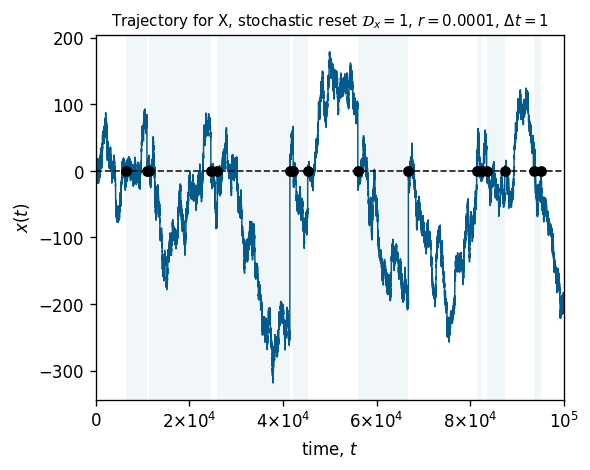

In [10]:
BrownianMotionLangevin.plot_trajectories(test)

## B.2. Simulate PDF

In [ ]:
BrownianMotionLangevin.plot_pdf(test)

## B.3. Simulate MSD


--------Started calculating MSD, X, stochastic resetting--------


100%|██████████| 100001/100001 [01:00<00:00, 1661.58it/s]


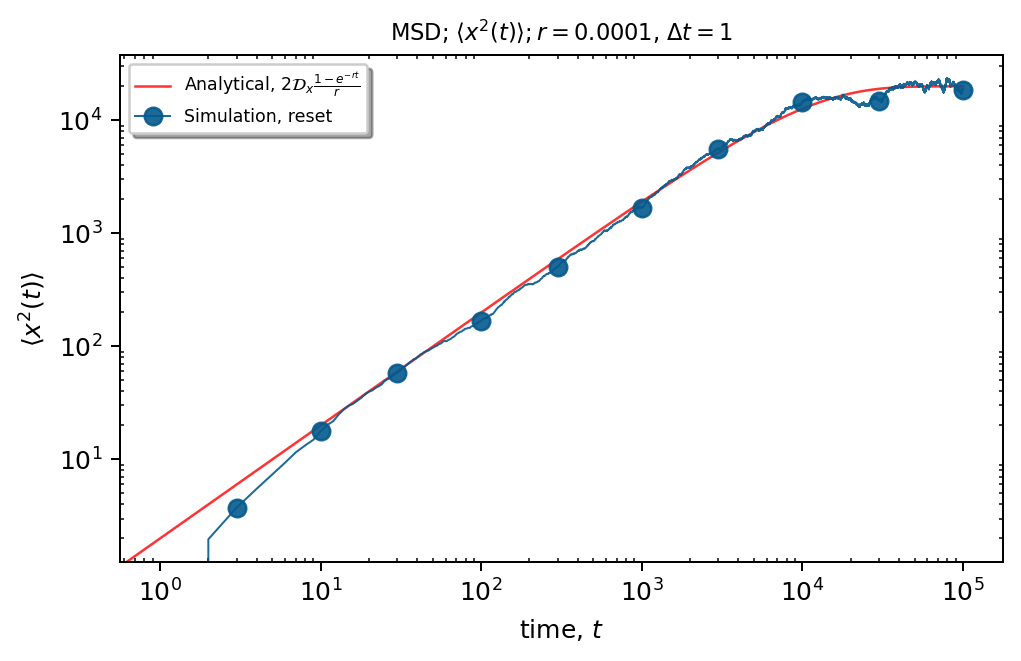

In [11]:
BrownianMotionLangevin.plot_msd(test)